In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle
import re
import pdb
import os

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from matplotlib import rc
rc('text', usetex=False)
from matplotlib.colors import to_rgb

from skimage.transform import resize
from skimage.io import imread
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as MSE

from polyphase.parallel import get_distance_matrix

# laplacian eigenmaps
from sklearn.manifold import spectral_embedding, MDS, Isomap
from sklearn.cluster import spectral_clustering
from scipy.sparse import csgraph
from scipy.linalg import eigvalsh

import polyphase as phase

In [3]:
# load the csv file with HTE data
allsys_df = pd.read_pickle('../expts/data/allsys_df.pkl')
htedf = pd.read_pickle('../data/htev2.pkl')
htedf.head()

,solvent,SM,polymer,chi12,chi13,chi23,dop,delta_solv,delta_SM,delta_polymer
0,Acetone,PC61BM,MDMO-PPV,0.440066,1.478520,1.90338,"[1626.0162601626018, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[19.06, 5.62, 5.28]"
1,Acetone,PC61BM,MEH-PPV,0.458907,1.532581,1.90338,"[948.509485094851, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[19.06, 5.38, 5.44]"
2,Acetone,PC61BM,P3HT,0.630290,2.719685,1.90338,"[117.82726522917405, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.56, 2.88, 3.19]"
3,Acetone,PC61BM,PFO,0.660927,2.507620,1.90338,"[1200.4944610849618, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.55, 2.8, 4.51]"
4,Acetone,PC61BM,PM6,0.468860,1.896708,1.90338,"[1436.3143631436315, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.37, 4.36, 4.19]"


In [4]:
def get_batch_of_phasediags(df, smstr, polymerstr):
    sys_df = df[(df['SM']==smstr) & (df['polymer']==polymerstr)]
    filename_list = []
    for _,row in sys_df.iterrows():
        fname = '../figures/hteplotsV2/{}_{}_{}.png'.format(row['solvent'], row['SM'], row['polymer'])
        filename_list.append(fname)
    
    return filename_list, sys_df

def get_ssim_distance(file0, file1):
    """ Given two image file names in file0, file1 compute distance"""
    
    img0 = imread(file0)
    img1 = imread(file1)
    img0 = resize(img0, (64,64))
    img1 = resize(img1, (64,64))
    d = ssim(img0, img1, multichannel=True)
    
    return 1-d

from skimage.color import rgb2gray

def get_grayscale_ssim(file0, file1):
    img0 = imread(file0)
    img1 = imread(file1)
    img0 = resize(img0, (64,64))
    img1 = resize(img1, (64,64))
    img0= rgb2gray(img0)
    img1= rgb2gray(img1)
    d = ssim(img0, img1)
    
    return 1-d


def get_MSE(file0, file1):
    img0 = imread(file0)
    img1 = imread(file1)
    img0 = resize(img0, (64,64))
    img1 = resize(img1, (64,64))
    d = MSE(img0, img1)
    return d

In [5]:
print('small molecules : ',  htedf['SM'].unique())
print('polymers: ', htedf['polymer'].unique())

small molecules :  ['PC61BM' 'PC71BM' 'DPP(TBFu)2' 'DPP(PhTT)2' 'Y6' 'IDTBR' 'IDIC']
polymers:  ['MDMO-PPV' 'MEH-PPV' 'P3HT' 'PFO' 'PM6' 'PTB7-Th']


In [6]:
class Store:
    def __init__(self):
        self.storage = []
 
    def save(self, array):
        self.storage.append(array)
        
    def __getitem__(self,index):
        return self.storage[index]
    
    def __len__(self):    
        return len(self.storage)
    
smstr = 'Y6'
polymerstr  = 'PM6'
files, sys_df = get_batch_of_phasediags(htedf, smstr, polymerstr)
data = Store()
for i,row in sys_df.iterrows():
    chi = [row['chi12'], row['chi13'], row['chi23']]
    M = row['dop']
    f = lambda x : phase.flory_huggins(x, M, chi)
    engine = phase.PHASE(f,100,3)
    engine.compute(use_parallel=False, verbose=False, lift_label=True)
    y = engine.df.loc['label',:].to_numpy().astype('int')
    
    data.save(y)


Computation took 0.76s
Computation took 0.59s
Computation took 0.58s
Computation took 0.44s
Computation took 0.56s
Computation took 0.52s
Computation took 0.77s
Computation took 0.43s
Computation took 0.60s
Computation took 0.56s
Computation took 0.46s
Computation took 0.43s
Computation took 0.66s
Computation took 0.44s
Computation took 0.44s
Computation took 0.74s
Computation took 0.58s
Computation took 0.81s
Computation took 0.53s
Computation took 0.55s
Computation took 0.53s
Computation took 0.57s
Computation took 0.60s
Computation took 0.53s
Computation took 0.59s
Computation took 0.53s
Computation took 0.54s
Computation took 0.52s
Computation took 0.56s
Computation took 0.57s
Computation took 0.53s
Computation took 0.54s
Computation took 0.53s
Computation took 0.54s
Computation took 0.58s
Computation took 0.58s
Computation took 0.53s
Computation took 0.51s
Computation took 0.53s
Computation took 0.53s
Computation took 0.52s
Computation took 0.54s
Computation took 0.53s
Computation

In [7]:
from scipy.spatial.distance import pdist, squareform, hamming
def distance_hamming(data, i,j):
    x = data[i[0]]
    y = data[j[0]]
    
    return hamming(x,y)

dist = lambda x,y: distance_hamming(data,x,y)
M = squareform(pdist(np.arange(len(data)).reshape(-1,1), dist))

from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axs = plt.subplots(1,2, dpi=300)
fig.subplots_adjust(wspace=0.5)
im = axs[0].imshow(M, cmap='bwr')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
axs[0].set_title('SSIM')

im = axs[1].imshow(X, cmap='bwr')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
axs[1].set_title('Affinity')

#plt.savefig('../figures/notebooks/PC61BM_PM6_Y6_PM6_heatmap.png', dpi=500, bbox_inches='tight')
plt.show()

fig, axs = plt.subplots(1,2, dpi=300)
fig.subplots_adjust(wspace=0.5)

axs[0].hist(M.flatten())
axs[0].set_title('SSIM')

axs[1].hist(X.flatten())
axs[1].set_title('Affinity')

#plt.savefig('../figures/notebooks/PC61BM_PM6_Y6_PM6.png', dpi=500, bbox_inches='tight')
plt.show()

# Dimensionality reduction

In [8]:
# create the affinity matrix
delta = M.std()
X = np.exp(- M ** 2 / (2. * delta ** 2))

X_local= X
M_local = M

## Multi dimensional scaling (MDS)
Since we have a metric from SSIM of phase diagrams, we can run the `metric multi-dimensional scaling` that tries to preserve the similarities between the data and embedding.

In [9]:
from numpy.linalg import norm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [10]:
def plot_embedding(embedding):

    fig = px.scatter(sys_df, x=embedding[:,0], y=embedding[:,1],
                     color=sys_df['delta_solv'].apply(lambda x: norm(x)), hover_data=['solvent','SM','polymer'],
                     color_continuous_scale=px.colors.sequential.RdBu
                    )
    fig.update_traces(marker=dict(size=12))
    fig.update_layout(coloraxis_colorbar=dict(title="Total solvent solubility"),
        plot_bgcolor='rgba(0,0,0,0)',yaxis = dict(showline=True)
                     )
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black',
                    ticks="outside", tickwidth=2, ticklen=10)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',
                    ticks="outside", tickwidth=2, ticklen=10)
    fig.update_layout(
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
    )
    
    return fig

In [11]:
embedding = MDS(n_components=3,  dissimilarity='precomputed', metric=True, random_state=0)
emb_mds = embedding.fit_transform(M)

# fig = plot_embedding(emb_mds)
# fig.show()

##  ISOMAP

Compute `isometric projection` of graph based geodesics into a two-dimensional euclidean space by `metric MDS`.

In [12]:
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform

embedding = Isomap(n_components=3,n_neighbors=5, metric='precomputed')
embedding.fit(M)
Dm = embedding.dist_matrix_
emb_isomap = embedding.embedding_

explained_variance = []
for dim in [1,2,3]:
    Dy = squareform(pdist(emb_isomap[:,:dim]))
    explained_variance.append(pearsonr(Dm.flatten(), Dy.flatten())[0])

# fig = plot_embedding(emb_isomap)
# fig.update_xaxes(title=r"Coordinate 1 ({:.2f}%)".format(explained_variance[0]*100))
# fig.update_yaxes(title=r"Coordinate 2 ({:.2f}%)".format(explained_variance[1]*100))

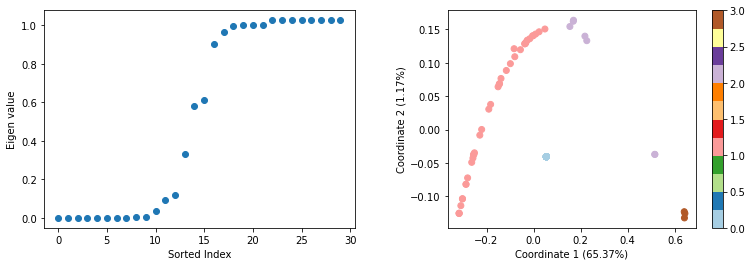

In [15]:
from sklearn.cluster import SpectralClustering
from scipy.spatial.distance import pdist, squareform

NUM_CLUSTERS = 4
clustering = SpectralClustering(n_clusters=NUM_CLUSTERS,assign_labels="discretize",random_state=0, affinity='precomputed')
D = squareform(pdist(emb_isomap, 'euclidean'))
delta = 0.01
A = np.exp(- D ** 2 / (2. * delta ** 2))
lowdim_labels = clustering.fit_predict(A)

laplacian = csgraph.laplacian(A, normed=True)
eigen_values = eigvalsh(laplacian)

fig, axs = plt.subplots(1,2, figsize=(2*4*1.6, 4))
fig.subplots_adjust(wspace=0.3)

num_eigs = 30
axs[0].scatter(np.arange(num_eigs),eigen_values[:num_eigs])
axs[0].set_xlabel('Sorted Index')
axs[0].set_ylabel('Eigen value')

pos = axs[1].scatter(emb_isomap[:,0], emb_isomap[:,1], c = lowdim_labels, cmap=plt.cm.Paired)
fig.colorbar(pos, ax=axs[1])
axs[1].set_xlabel(r"Coordinate 1 ({:.2f}%)".format(explained_variance[0]*100))
axs[1].set_ylabel(r"Coordinate 2 ({:.2f}%)".format((explained_variance[1]-explained_variance[0])*100))

plt.show()

In [16]:
from mpl_toolkits.axes_grid1 import ImageGrid
from math import floor, ceil

def plot_clustered_diagrams_grid(cluster_id, labels):
    cluster_diags = sys_df.loc[labels==cluster_id]
    
    num_images = len(cluster_diags)

    # Two pairs of `nrows, ncols` are possible
    k = (num_images * 12)**0.5
    r1 = max(1, floor(k / 4))
    r2 = ceil(k / 4)
    c1 = ceil(num_images / r1)
    c2 = ceil(num_images / r2)

    # Select the one which is closer to 4:3
    if abs(r1 / c1 - 0.75) < abs(r2 / c2 - 0.75):
        nrows, ncols = r1, c1
    else:
        nrows, ncols = r2, c2

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows,ncols))
    axes = np.asarray(axes).ravel()
    axis_id = 0
    for ax, (_,row) in zip(axes, cluster_diags.iterrows()):
        fname = '../figures/hteplotsV2/{}_{}_{}.png'.format(row['solvent'],row['SM'],row['polymer'])
        img = plt.imread(fname)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title('{}'.format(cluster_id))
        axis_id += 1
        
    for i in range(axis_id,int(nrows*ncols)):
        axes[i].axis('off')
        
    return fig

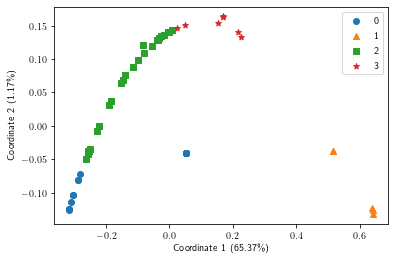

In [17]:
from matplotlib import rcParams
rcParams.update({"text.usetex": True})
highdim_labels = clustering.fit_predict(X)
fig, ax = plt.subplots()
label_markers = ['o','^','s','*']
for i in np.unique(highdim_labels):
    ax.scatter(emb_isomap[highdim_labels==i,0], emb_isomap[highdim_labels==i,1], 
               marker=label_markers[i], label=str(i))
ax.legend()                                                                                            
ax.set_xlabel(r"Coordinate 1 ({:.2f}\%)".format(explained_variance[0]*100))
ax.set_ylabel(r"Coordinate 2 ({:.2f}\%)".format((explained_variance[1]-explained_variance[0])*100))
#plt.savefig('../figures/notebooks/PM6_Y6_DR.png', dpi=300, bbox_inches='tight')
plt.show()


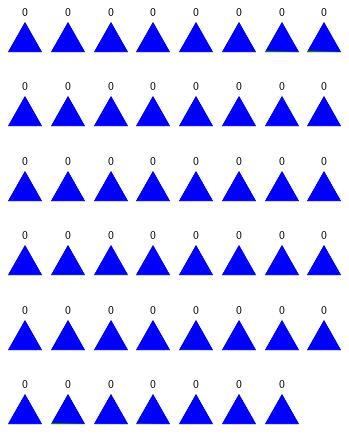

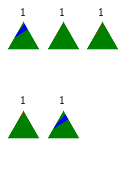

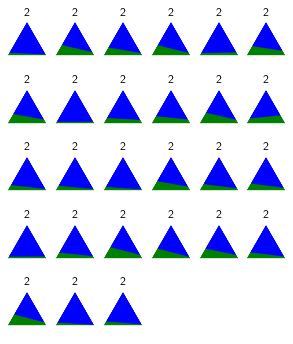

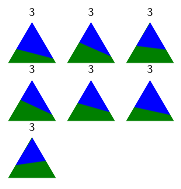

In [18]:
for i in range(4):
    fig = plot_clustered_diagrams_grid(i, highdim_labels)
    plt.show()